In [1]:
from Neuron_analysis_tool.Analyzer import Analyzer, long_pulse_protocol
from Neuron_analysis_tool.utils import video_player
from pathlib import Path
from neuron import gui, h
import numpy as np
import os
import matplotlib.pyplot as plt

NEURON mechanisms not found in /ems/elsc-labs/segev-i/yoni.leibner/PycharmProjects/Neuron_analysis_tool/Neuron_analysis_tool/x86_64/special.


NEURON: unable to open font "*helvetica-medium-r-normal*--14*", using "fixed"


## Loading rall model

In [2]:
analyser = Analyzer(type='L5PC')

## plot the cell morphology

error in geting morph part from section: L5PCtemplate[0].axon[0]
error in geting morph part from section: L5PCtemplate[0].axon[1]


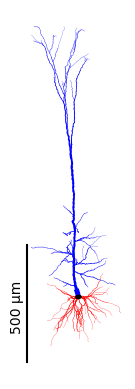

In [3]:
_,_,_=analyser.plot_morph(scale=500, diam_factor=0.5, theta=-90, ignore_soma=True)

### adding a protocol of random synapses

In [6]:
def add_syn(seg, g_AMPA=0.0004, g_NMDA=0.0004):
    netstim = h.NetStim()
    netstim.interval = 400 # fr of 1
    netstim.start = 400
    netstim.noise = 1.0
    netstim.number = 0
    # AMPA part
    AMPA = h.Exp2Syn(seg.x, sec=seg.sec)
    AMPA_con= h.NetCon(netstim, AMPA)
    AMPA.e = 0
    AMPA.tau1 = 0.3
    AMPA.tau2 = 1.5
    AMPA_con.weight[0] = g_AMPA
    AMPA_con.delay = 0

    # NMDA part
    NMDA=h.NMDA(seg.x, sec=seg.sec)
    NMDA_con = h.NetCon(netstim, NMDA)
    NMDA.e = 0
    NMDA.tau_r_NMDA = 8
    NMDA.tau_d_NMDA = 35
    NMDA.n_NMDA = 0.27
    NMDA.gama_NMDA = 0.076
    NMDA_con.weight[0] = g_NMDA
    NMDA_con.delay = 0
    return [AMPA, AMPA_con], [NMDA, NMDA_con], netstim

def add_isyn(seg, g_GABA=0.0004):
    netstim = h.NetStim()
    netstim.interval = 500 # fr of 1
    netstim.start = 400
    netstim.noise = 1.0
    netstim.number = 0
    # AMPA part
    AMPA = h.Exp2Syn(seg.x, sec=seg.sec)
    AMPA_con= h.NetCon(netstim, AMPA)
    AMPA.e = -100
    AMPA.tau1 = 0.2
    AMPA.tau2 = 4
    AMPA_con.weight[0] = g_GABA
    AMPA_con.delay = 0

    return [AMPA, AMPA_con], netstim


def random_syn_protocol(cell, start_seg):
    syns = []
    isyns = []
    segs_e = []
    syn_e_times = []
    
    segs_i = []
    syn_i_times = []
    
    start_time_= 400
    total_time = 1000+start_time_#1400
    
    number_of_e_syns = 5000
    number_of_i_syns = 2000
    
    amp=0
    e_FR = 2 #Hz
    i_FR = 2 #Hz
    #difining the synapses times
    sim_time = total_time-start_time_
    valid_segments = []
    for sec in cell.dend:
        for seg in sec:
            valid_segments+=[seg]*40
    for sec in cell.apic:
        for seg in sec:
            valid_segments+=[seg]*40
    
    segs_for_syns = np.random.choice(valid_segments, number_of_e_syns+number_of_i_syns, replace=False)
    for seg in segs_for_syns[:number_of_e_syns]:
        segs_e.append(seg)
        syns.append(add_syn(seg))
        syn_time = np.random.rand(int(np.ceil(sim_time/1000.0*e_FR))) * sim_time + start_time_
        syn_e_times.append(syn_time)

    for seg in segs_for_syns[-number_of_i_syns:]:
        segs_i.append(seg)
        isyns.append(add_isyn(seg))
        syn_time = np.random.rand(int(np.ceil(sim_time/1000.0*i_FR))) * sim_time + start_time_
        syn_i_times.append(syn_time)

    #function to insert synapse time to neuron
    def event_setter():
        for syn, times in zip(syns, syn_e_times):
            for t in times:
                syn[0][1].event(t) #AMPA netcon
                syn[1][1].event(t) #NMDA netcon          
        for syn, times in zip(isyns, syn_i_times):
            for t in times:
                syn[0][1].event(t) #GABA netcon
    
    # this function is return to the movie maker and is called every frame generation, than one can add stuff to the frame.
    # you must return all the new created items, so the function can call .remove() to remove this items in the next frame
    
    def draw_func1(start_time, end_time, segs, lines, ax, records):
        elements = []
        start_time+=start_time_
        end_time+=start_time_
        
        for seg, syn, times in zip(segs_e, syns, syn_e_times):
            for t in times:
                if t>start_time and t< end_time:
                    if seg in segs:
                        l = lines[segs==seg][0]
                        try:
                            elements.append(ax.scatter(l.get_xdata().mean(), l.get_ydata().mean(), color='r', alpha=0.75, s=10))
                        except:
                            pass
        for seg, syn, times in zip(segs_i, isyns, syn_i_times):
            for t in times:
                if t>start_time and t< end_time:
                    if seg in segs:
                        l = lines[segs==seg][0]
                        try:
                            elements.append(ax.scatter(l.get_xdata().mean(), l.get_ydata().mean(), color='b', alpha=0.75, s=10))
                        except:
                            pass
        return elements
        

    h.tstop = total_time
    h.v_init = cell.soma[0].e_pas
    h.celsius = 37
    fih=h.FInitializeHandler(0, event_setter)
    h.run()
    return start_time_, dict(draw_funcs=[draw_func1])

In [7]:
records, extra = analyser.record_protocol(protocol=random_syn_protocol, record_names=['v'])

error in geting morph part from section: L5PCtemplate[0].axon[0]
error in geting morph part from section: L5PCtemplate[0].axon[1]
duration= 50.00000000015643
Moviepy - Building video videos/synapses/all_with_synapses_location.mp4.
Moviepy - Writing video videos/synapses/all_with_synapses_location.mp4



Moviepy - Done !
Moviepy - video ready videos/synapses/all_with_synapses_location.mp4


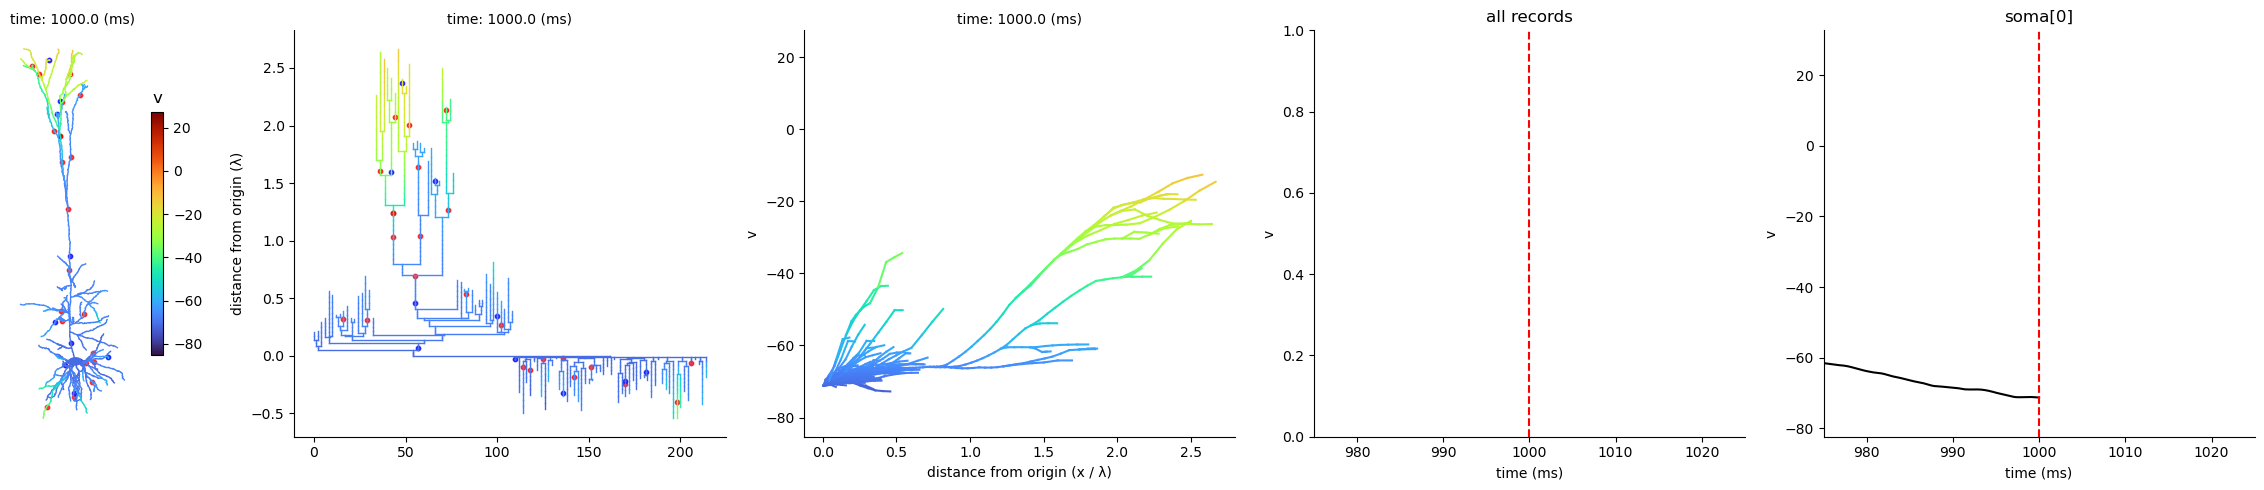

In [9]:
fig, ax = plt.subplots(1, 5, figsize=(25,5))
soma_seg = list(analyser.cell.soma[0])[0]

hot_spot_seg = list(analyser.cell.apic[36])[0]
record_dict = records.all_records['v']
draw_funcs = extra['draw_funcs']
plot_kwargs = [
    dict(ax=ax[0], seg = soma_seg, records=record_dict, electrical=False, plot_type='morph', 
         plot_color_bar=True, theta=-90, draw_funcs=draw_funcs),
    dict(ax=ax[1], seg = soma_seg, records=record_dict, electrical=True, plot_type='dendogram', 
         plot_color_bar=False, draw_funcs=draw_funcs),
    dict(ax=ax[2], seg = soma_seg, records=record_dict, electrical=True, plot_type='attenuation'),
    dict(ax=ax[3], seg = soma_seg, records=record_dict, distance_factor=0, plot_every=0.25, 
         plot_type='all_records'),
    dict(ax=ax[4], seg = soma_seg, records=record_dict, plot_type='single_record'),
              ]
f = lambda: plt.tight_layout()
slow_down_factor=50
videos_folder = 'videos/synapses/'
video_name = 'all_with_synapses_location.mp4'
os.makedirs(videos_folder, exist_ok=True)
analyser.save_movie_from_rec(fig=fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs, 
                             func_before_run=[f], save_to=videos_folder, clip_name=video_name, fps=10, 
                             threads=16, preset='ultrafast')
video_player(Path.cwd(), videos_folder+video_name)

In [6]:
def add_syn(seg, g_AMPA=0.0004, g_NMDA=0.0004):
    netstim = h.NetStim()
    netstim.interval = 400 # fr of 1
    netstim.start = 400
    netstim.noise = 1.0
    netstim.number = 0
    # AMPA part
    AMPA = h.Exp2Syn(seg.x, sec=seg.sec)
    AMPA_con= h.NetCon(netstim, AMPA)
    AMPA.e = 0
    AMPA.tau1 = 0.3
    AMPA.tau2 = 1.5
    AMPA_con.weight[0] = g_AMPA
    AMPA_con.delay = 0

    # NMDA part
    NMDA=h.NMDA(seg.x, sec=seg.sec)
    NMDA_con = h.NetCon(netstim, NMDA)
    NMDA.e = 0
    NMDA.tau_r_NMDA = 8
    NMDA.tau_d_NMDA = 35
    NMDA.n_NMDA = 0.27
    NMDA.gama_NMDA = 0.076
    NMDA_con.weight[0] = g_NMDA
    NMDA_con.delay = 0
    return [AMPA, AMPA_con], [NMDA, NMDA_con], netstim

def add_isyn(seg, g_GABA=0.0004):
    netstim = h.NetStim()
    netstim.interval = 500 # fr of 1
    netstim.start = 400
    netstim.noise = 1.0
    netstim.number = 0
    # AMPA part
    AMPA = h.Exp2Syn(seg.x, sec=seg.sec)
    AMPA_con= h.NetCon(netstim, AMPA)
    AMPA.e = -100
    AMPA.tau1 = 0.2
    AMPA.tau2 = 4
    AMPA_con.weight[0] = g_GABA
    AMPA_con.delay = 0

    return [AMPA, AMPA_con], netstim


def random_syn_protocol_NMDA_ditact(cell, start_seg):
    syns = []
    isyns = []
    segs_e = []
    syn_e_times = []
    
    segs_i = []
    syn_i_times = []
    g_NMDA_rec = []
    start_time_= 400
    total_time = 1000+start_time_#1400
    
    number_of_e_syns = 5000
    number_of_i_syns = 2000
    g_max_NMDA=0.0004
    
    amp=0
    e_FR = 2 #Hz
    i_FR = 2 #Hz
    #difining the synapses times
    sim_time = total_time-start_time_
    for sec in np.random.choice(list(cell.all), number_of_e_syns):
        
        seg_num = np.random.randint(0, len(list(sec)))
        segs_e.append(list(sec)[seg_num])
        syns.append(add_syn(list(sec)[seg_num], g_NMDA=g_max_NMDA))
        syn_time = np.random.rand(int(np.ceil(sim_time/1000.0*e_FR))) * sim_time + start_time_
        syn_e_times.append(syn_time)
        g_NMDA_rec.append(h.Vector())
        g_NMDA_rec[-1].record(syns[-1][1][0]._ref_g_NMDA)
        

    for sec in np.random.choice(list(cell.all), number_of_i_syns):
        seg_num = np.random.randint(0, len(list(sec)))
        segs_i.append(list(sec)[seg_num])
        isyns.append(add_isyn(list(sec)[seg_num]))
        syn_time = np.random.rand(int(np.ceil(sim_time/1000.0*i_FR))) * sim_time + start_time_
        syn_i_times.append(syn_time)

    #function to insert synapse time to neuron
    def event_setter():
        for syn, times in zip(syns, syn_e_times):
            for t in times:
                syn[0][1].event(t) #AMPA netcon
                syn[1][1].event(t) #NMDA netcon          
        for syn, times in zip(isyns, syn_i_times):
            for t in times:
                syn[0][1].event(t) #GABA netcon
    
    # this function is return to the movie maker and is called every frame generation, than one can add stuff to the frame.
    # you must return all the new created items, so the function can call .remove() to remove this items in the next frame
    
    def draw_func1(start_time, end_time, segs, lines, ax, records):
        elements = []
        start_time+=start_time_
        end_time+=start_time_
        
        for seg, syn, times in zip(segs_e, syns, syn_e_times):
            for t in times:
                if t>start_time and t< end_time:
                    if seg in segs:
                        l = lines[segs==seg][0]
                        try:
                            elements.append(ax.scatter(l.get_xdata().mean(), l.get_ydata().mean(), color='r', alpha=0.75, s=10))
                        except:
                            pass
        for seg, syn, times in zip(segs_i, isyns, syn_i_times):
            for t in times:
                if t>start_time and t< end_time:
                    if seg in segs:
                        l = lines[segs==seg][0]
                        try:
                            elements.append(ax.scatter(l.get_xdata().mean(), l.get_ydata().mean(), color='b', alpha=0.75, s=10))
                        except:
                            pass
        return elements
    
    def draw_func2(start_time, end_time, segs, lines, ax, records):
        
#         start_time+=start_time_
#         end_time+=start_time_
        NMDA_present_thresh=0.3
        # extracting g_NMDA records
        for i in range(len( g_NMDA_rec)):
            if not (type(g_NMDA_rec[i]) == np.ndarray):
                g_NMDA_rec[i] = records.extraction_func(g_NMDA_rec[i])
        
        # detact g_NMDA
        elements = []
        time = records.time
        for seg, syn, gNMDA_syn in zip(segs_e, syns, g_NMDA_rec):
            if (gNMDA_syn[np.logical_and(time>start_time, time<=end_time)]>NMDA_present_thresh*g_max_NMDA).sum()>=1:
                if seg in segs:
                    l = lines[segs==seg][0]
                    try:
                        elements.append(ax.scatter(l.get_xdata().mean(), l.get_ydata().mean(), color='cyan', alpha=0.5, s=100))
                    except:
                        pass
        return elements
        

    h.tstop = total_time
    h.v_init = cell.soma[0].e_pas
    h.celsius = 37
    fih=h.FInitializeHandler(0, event_setter)
    h.run()
    return start_time_, dict(draw_funcs=[draw_func1, draw_func2])

In [7]:
records, extra = analyser.record_protocol(protocol=random_syn_protocol_NMDA_ditact, record_names=['v'])

AttributeError: 'hoc.HocObject' object has no attribute 'sec'

NEURON: Python Callback failed
 near line 0
 ^
        finitialize(-90)
      init()
    stdinit()
  run()


RuntimeError: hoc error

In [3]:
# fig, ax = plt.subplots(1, 5, figsize=(25,5))
# soma_seg = list(analyser.cell.soma[0])[0]

# hot_spot_seg = list(analyser.cell.apic[36])[0]
# record_dict = records.all_records['v']
# draw_funcs = extra['draw_funcs']
# plot_kwargs = [
#     dict(ax=ax[0], seg = soma_seg, records=record_dict, electrical=False, plot_type='morph', 
#          plot_color_bar=True, theta=-90, draw_funcs=draw_funcs),
#     dict(ax=ax[1], seg = soma_seg, records=record_dict, electrical=True, plot_type='dendogram', 
#          plot_color_bar=False, draw_funcs=draw_funcs),
#     dict(ax=ax[2], seg = soma_seg, records=record_dict, electrical=True, plot_type='attenuation'),
#     dict(ax=ax[3], seg = soma_seg, records=record_dict, distance_factor=0, plot_every=0.25, 
#          plot_type='all_records'),
#     dict(ax=ax[4], seg = soma_seg, records=record_dict, plot_type='single_record'),
#               ]
# f = lambda: plt.tight_layout()
# slow_down_factor=50
videos_folder = 'videos/synapses/'
video_name = 'all_with_synapses_location_NMDA_ditact.mp4'
# os.makedirs(videos_folder, exist_ok=True)
# analyser.save_movie_from_rec(fig=fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs, f=[f], 
#                              save_to=videos_folder, clip_name=video_name, fps=10, 
#                              threads=16, preset='ultrafast')
video_player(Path.cwd(), videos_folder+video_name)

### detacting Ca spikes on the gCa_LVAst conductance

In [11]:
def Ca_spike_protocol(cell, start_seg):
    delay=400.0
    stim = h.IClamp(0.5, sec=cell.soma[0])
    stim.dur   = 5
    stim.delay = delay

    syn = h.epsp(cell.apic[36](0.9))
    syn.tau0  = 0.5
    syn.tau1 = 5
    syn.onset   = stim.delay + 5
    syn.imax = 0.5 
    stim.amp = 1.9
    
    h.tstop = 700
    h.v_init = cell.soma[0].e_pas
    h.celsius = 37
    h.run()
    
    
    def draw_func1(start_time, end_time, segs, lines, ax, records):
        if start_time >= end_time: return []
        elements = []
        for seg, l in zip(segs, lines):
            if records.is_existing(seg):
                r = records.get_record_at_dt(seg, start_time, end_time, dt_func = lambda x: np.max(x))
                if r > 0.00015:
                    elements.append(ax.scatter(l.get_xdata().mean(), l.get_ydata().mean(), color='r', alpha=0.75, s=100))
        return elements
        

    return 400, dict(draw_funcs=[draw_func1])

optimizing lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 97727.48it/s]


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


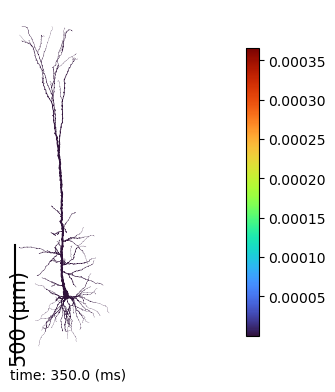

In [12]:
show_records_from = dict()

record_dict, draw_funcs = analyser.record_protocol(protocol=Ca_spike_protocol, cut_start_ms=None, 
                                          record_name='gCa_LVAst_Ca_LVAst')

animation = analyser.create_movie_from_rec(records=record_dict, slow_down_factor=50, 
                                           func_for_missing_frames=np.max, theta=-90, diam_factor=0.5, 
                                           show_records_from=show_records_from, seg_to_indicate_dict=dict(),
                                          draw_funcs=draw_funcs)

animation.ipython_display(fps=10, loop=True, autoplay=True)

### detacting NMDA spikes on the gNMDA conductance ploted on the voltage response

In [ ]:


def random_syn_protocol_NMDA_ditact(cell, start_seg):
    syns = []
    isyns = []
    segs_e = []
    syn_e_times = []
    
    segs_i = []
    syn_i_times = []
    
    total_time = 1400
    start_time=400
    number_of_e_syns = 5000
    number_of_i_syns = 2000
    g_max_NMDA=0.0004
    amp=0
    e_FR = 2 #Hz
    i_FR = 2 #Hz
    #difining the synapses times
    sim_time = total_time-start_time
    g_NMDA_rec = []
    for sec in np.random.choice(list(cell.all), number_of_e_syns):
        
        seg_num = np.random.randint(0, len(list(sec)))
        segs_e.append(list(sec)[seg_num])
        syns.append(add_syn(list(sec)[seg_num], g_NMDA=g_max_NMDA)) # [AMPA, AMPA_con], [NMDA, NMDA_con], netstim
        g_NMDA_rec.append(h.Vector())
        g_NMDA_rec[-1].record(syns[-1][1][0]._ref_g_NMDA)
        syn_time = np.random.rand(int(np.ceil(sim_time/1000.0*e_FR))) * sim_time
        syn_e_times.append(syn_time)
        
    for sec in np.random.choice(list(cell.all), number_of_i_syns):
        seg_num = np.random.randint(0, len(list(sec)))
        segs_i.append(list(sec)[seg_num])
        isyns.append(add_isyn(list(sec)[seg_num]))
        syn_time = np.random.rand(int(np.ceil(sim_time/1000.0*i_FR))) * sim_time
        syn_i_times.append(syn_time)

    #function to insert synapse time to neuron
    def event_setter():
        for syn, times in zip(syns, syn_e_times):
            for t in times:
                syn[0][1].event(t) #AMPA netcon
                syn[1][1].event(t) #NMDA netcon          
        for syn, times in zip(isyns, syn_i_times):
            for t in times:
                syn[0][1].event(t) #GABA netcon
    
    # this function is return to the movie maker and is called every frame generation, than one can add stuff to the frame.
    # you must return all the new created items, so the function can call .remove() to remove this items in the next frame
    def draw_func1(start_time, end_time, segs, lines, ax, records):
        elements = []
        for seg, syn, times in zip(segs_e, syns, syn_e_times):
            for t in times:
                if t>start_time and t< end_time:
                    if seg in segs:
                        l = lines[segs==seg][0]
                        try:
                            elements.append(ax.scatter(l.get_xdata().mean(), l.get_ydata().mean(), color='r', alpha=0.75, s=10))
                        except:
                            pass
        for seg, syn, times in zip(segs_i, isyns, syn_i_times):
            for t in times:
                if t>start_time and t< end_time:
                    if seg in segs:
                        l = lines[segs==seg][0]
                        try:
                            elements.append(ax.scatter(l.get_xdata().mean(), l.get_ydata().mean(), color='b', alpha=0.75, s=10))
                        except:
                            pass
        return elements
    
    def draw_func2(start_time, end_time, segs, lines, ax, records):
#         detact g_NMDA
        for i in range(len( g_NMDA_rec)):
            if not (type(g_NMDA_rec[i]) == np.ndarray):
                g_NMDA_rec[i] = records.extraction_func(g_NMDA_rec[i])
        elements = []
        time= records.time
        for seg, syn, gNMDA_syn in zip(segs_e, syns, g_NMDA_rec):
            if (gNMDA_syn[np.logical_and(time>start_time, time<=end_time)]>0.3*g_max_NMDA).sum()>=1:
                if seg in segs:
                    l = lines[segs==seg][0]
                    try:
                        elements.append(ax.scatter(l.get_xdata().mean(), l.get_ydata().mean(), color='cyan', alpha=0.5, s=100))
                    except:
                        pass
        return elements
        

    h.tstop = total_time
    h.v_init = cell.soma[0].e_pas
    h.celsius = 37
    fih=h.FInitializeHandler(0, event_setter)
    h.run()
    return start_time, dict(draw_funcs=[draw_func1, draw_func2])

In [ ]:
show_records_from = dict()
show_records_from[list(analyser.cell.soma[0])[0]] = dict(label='soma', alpha=0.75, color='lime', size=50)
show_records_from[list(analyser.cell.apic[36])[0]] = dict(label='dend1', alpha=0.75, color='grey', size=40)

record_dict, extra = analyser.record_protocol(protocol=random_syn_protocol_NMDA_ditact, cut_start_ms=None, record_name='v')
animation = analyser.create_movie_from_rec(records=record_dict, slow_down_factor=50, 
                                           func_for_missing_frames=np.max, theta=-90, diam_factor=None, 
                                           show_records_from=show_records_from, seg_to_indicate_dict=dict(), 
                                           draw_funcs=extra['draw_funcs'], base_plot_type='dendogram', figsize=(10,10), dancing=False)
animation.ipython_display(fps=10, loop=True, autoplay=True)


In [ ]:
animation = analyser.create_movie_from_rec(records=record_dict, slow_down_factor=50, 
                                           func_for_missing_frames=np.max, theta=-90, diam_factor=None, 
                                           show_records_from=show_records_from, seg_to_indicate_dict=dict(), 
                                           draw_funcs=extra['draw_funcs'], figsize=(10,10), dancing=False, 
                                           electrical=False)
animation.ipython_display(fps=10, loop=True, autoplay=True)


In [ ]:
color_bar_idx

In [ ]:
vertical

In [ ]:
divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='10%', pad=0.6)
cb = fig.colorbar(heatmap, cax=cax, orientation='horizontal')


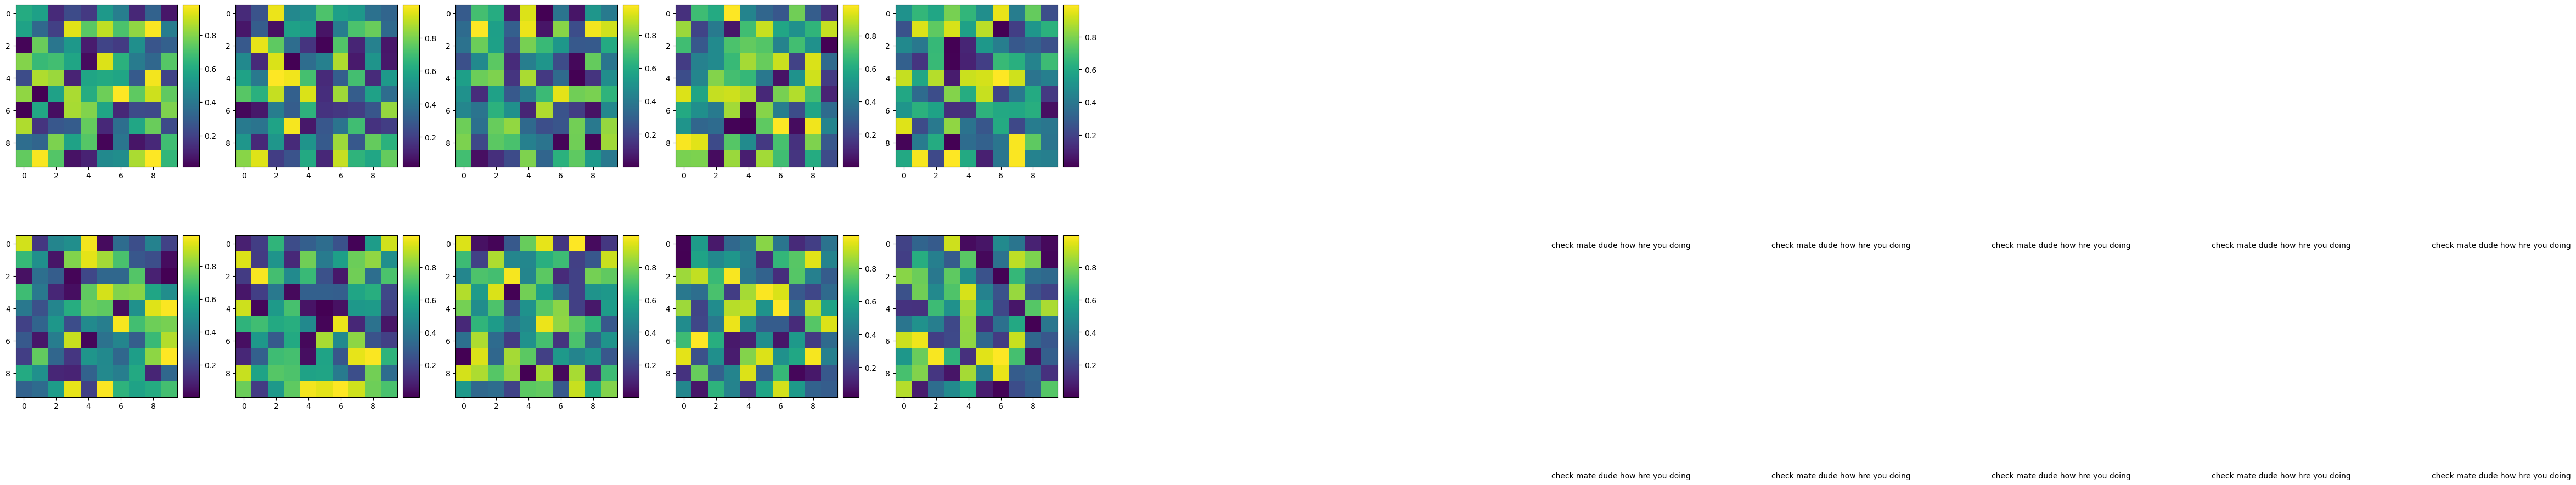

In [60]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(2, 5, figsize=(25,10))
for ax_ in ax:
    for a in ax_:
        heatmap = a.imshow(np.random.rand(10, 10))
#         a.text(a.get_xlim()[1], a.get_ylim()[1], 'check')
        divider = make_axes_locatable(a)
        cax = divider.append_axes('right', size="10%", pad=0.1)
#         cax.set_aspect(5, anchor='C')
#         cax
        cb = fig.colorbar(heatmap, cax=cax, orientation='vertical') #horizontal
        txt = a.text(a.get_xlim()[1], a.get_ylim()[1], 'check mate dude how hre you doing', wrap=True)
        txt.set_clip_on(False) 

plt.tight_layout()

In [46]:
cax.get_xlim()

(0.0008387159975321579, 0.9998710566456444)

In [18]:
cax.set_aspect(50)

In [37]:
a.get_xlim()[1]

19.5

Text(0.5, 1.0, '$check_{2}$')

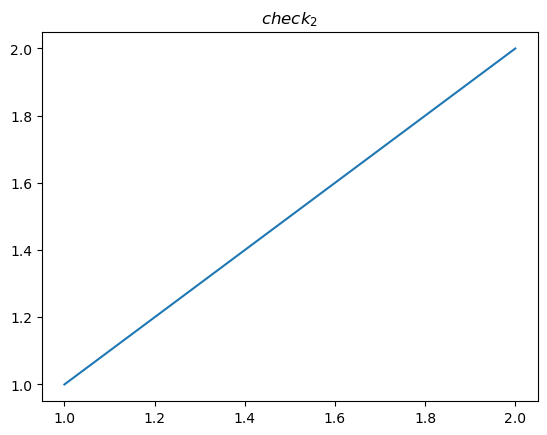

In [11]:
fig, ax = plt.subplots(1)
ax.plot([1,2], [1,2])
ax.set_title('$check_{2}$')